## Angle vs. Time Plot of Pendulums

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

#### Load angles from file

The experiment is conducted with pendulums modeled with a lock hanging on a thin string. Experiment is repeated with different rest lengths of the string. However, the actual length of the pendulum may be longer due to the stretch of the string and the size of the lock.

A one-minute video of the pendulum is recorded and the motion of the pendulum is tracked using OpenCV. The CSV files with the time and the UV coordinates of the pendulum relative to a rectangular frame is stored under `csv/uvt-{length}.csv`. The width of the frame is 0.98m and the height of the frame is 1.36m. One end of the string is tied on the middle of the top of the frame.

In [2]:
LENGTHS = [20, 30, 40, 50, 60, 70, 80]
WIDTH, HEIGHT = 0.98, 1.36

data = {}
for length in LENGTHS:
    # load data from file
    with open(f"csv/uvt-{length}.csv", 'r') as fp:
        lines = fp.read().strip().replace('\r', '').split('\n')
        content = [list(map(float, line.split(','))) for line in lines]
        content = np.array(content, dtype=np.float64)
    # get length and angle
    t = content[:, 0]
    x = WIDTH * (content[:, 1] - 0.5)
    y = HEIGHT * content[:, 2]
    r = np.hypot(x, y)
    a = np.arctan2(x, y)
    # remove data points with abnormal lengths
    # possibly due to tracking error
    medr = np.median(r)
    i = np.where((0.85 * r < medr) & (medr < 1.15 * r))
    t, x, y, r, a = t[i], x[i], y[i], r[i], a[i]
    if False:
        plt.plot(t, r)
        plt.show()
    # save processed data
    l = np.median(r)
    l_uncert = max(abs(r-l))
    print("Length: {:.2f} m ± {:.2f} m".format(l, l_uncert))
    data[length] = {
        't': t,
        'l': l,
        'l_uncert': l_uncert,
        'a': a-np.mean(a)  # angle measuring shift
    }

Length: 0.28 m ± 0.03 m
Length: 0.38 m ± 0.05 m
Length: 0.48 m ± 0.04 m
Length: 0.57 m ± 0.03 m
Length: 0.67 m ± 0.03 m
Length: 0.77 m ± 0.06 m
Length: 0.88 m ± 0.03 m


Plot a random angle-time graph to see if it looks right

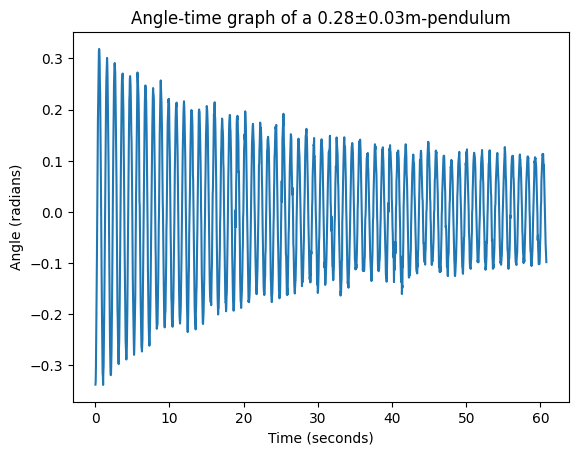

In [3]:
sample_data = data[20]
plt.clf()
plt.title("Angle-time graph of a {:.2f}±{:.2f}m-pendulum".format(
    sample_data['l'], sample_data['l_uncert']))
plt.xlabel("Time (seconds)")
plt.ylabel("Angle (radians)")
plt.plot(sample_data['t'], sample_data['a'])
plt.show()

#### Fit the data

Linearly damped harmonic oscillator model

$\theta(t) = \theta_0 \operatorname{e}^{-t/\tau} \cos\left(2\pi\frac{t}{T}+\phi_0\right)$

period, phase guesses: 1.0139507707748951 2.691465972109323
20 [ 0.28452704 48.10044118  1.03090915  2.64803483]
Q factor: 146.58129003737588


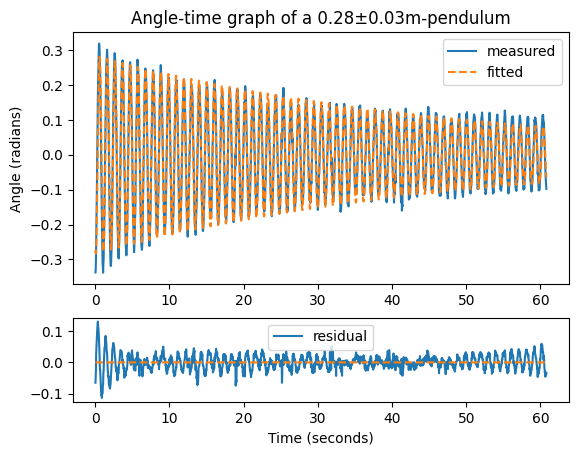

period, phase guesses: 1.2195897419455115 -0.6866440224027887
30 [ 0.31704347 70.2326261   1.22452075 -1.65600861]
Q factor: 180.18665780610172


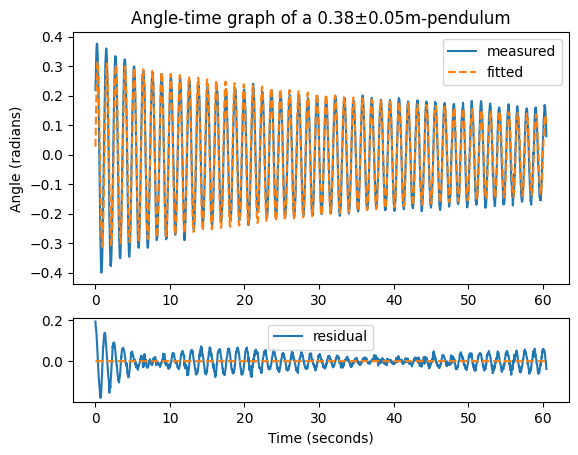

period, phase guesses: 1.37259417482433 -0.007570773496768735
40 [ 0.40685713 88.80451956  1.38341765  1.06091114]
Q factor: 201.66551092611058


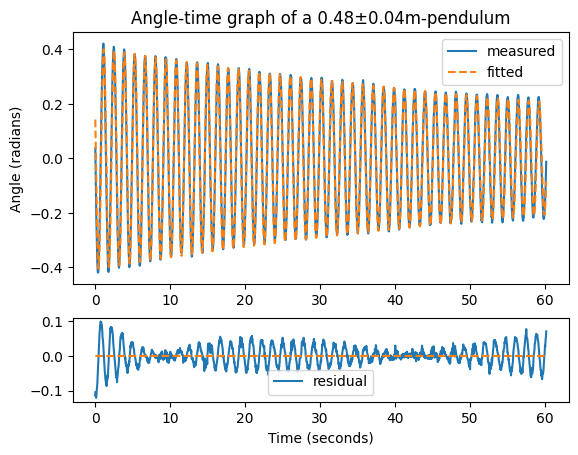

period, phase guesses: 1.4706955208617802 1.072170284023735
50 [  0.4719768  106.72227697   1.52486698   1.4727592 ]
Q factor: 219.8735537000465


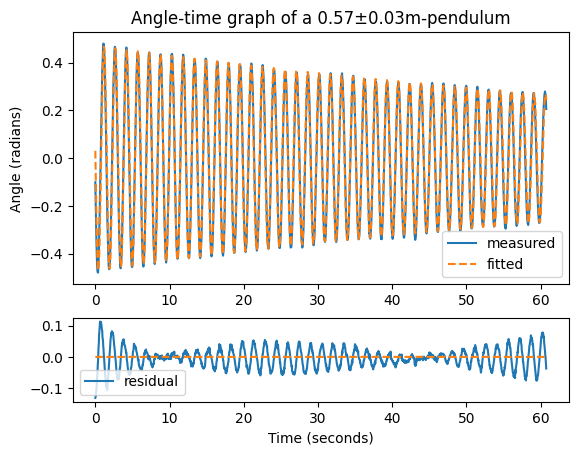

period, phase guesses: 1.6221220903588043 1.6354549680373243
60 [  0.43191813 121.67319504   1.65319969   1.27390781]
Q factor: 231.2168447867352


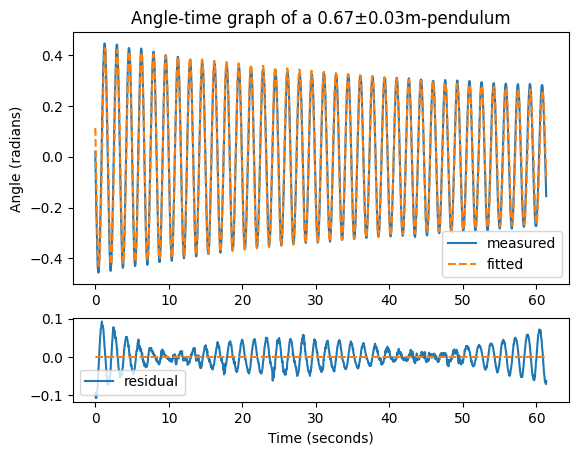

period, phase guesses: 1.6610846453444075 -1.7420554018202692
70 [  0.47078125 119.44899147   1.78147868  -1.59202903]
Q factor: 210.6452791031174


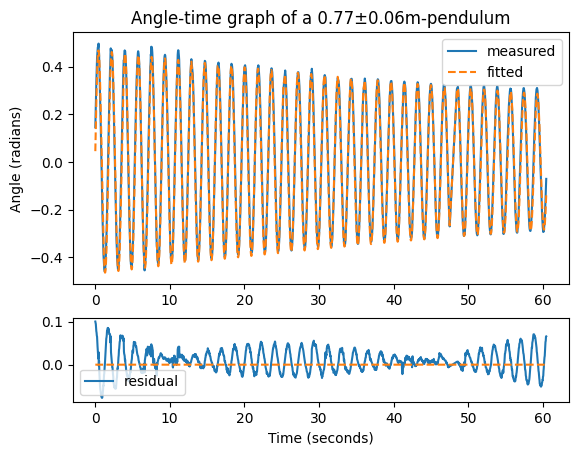

period, phase guesses: 1.8192591686233004 1.1901052802632428
80 [  0.46487505 144.83961272   1.89527551   1.03669951]
Q factor: 240.0849164301039


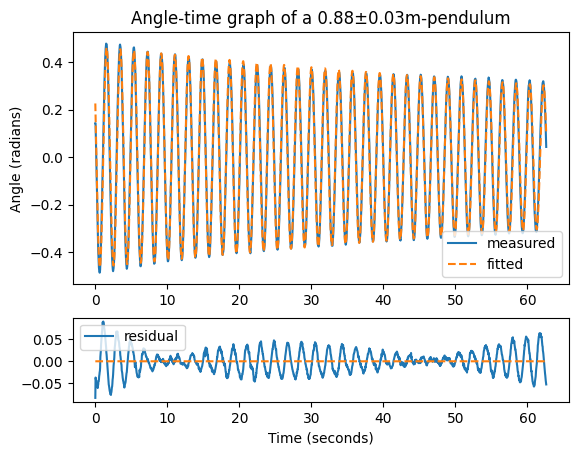

In [4]:
def damped_harmonic(t, a0, tau, period, phase):
    a = a0 * np.exp(-t/tau)
    # a = a0 / (1.0 + t/tau)
    # a = a0 / np.sqrt(1.0 + 2.0*t/tau)
    # a = a0 / (1.0+0.5*t/tau)**2
    return a * np.cos(2.*np.pi*t/period + phase)

def fit_data(t, a):
    # guess period and frequency
    tot_t = t[-1]*(len(t)+1)/len(t)
    t_ = tot_t * np.arange(1024)/1024
    a_ = np.interp(t_, t, a)
    af = np.fft.fft(a_)[:len(a_)//2]
    ai = np.argmax(abs(af))
    coes = np.polyfit([ai-1, ai, ai+1], abs(af)[ai-1:ai+2], 2)
    ai = -coes[1]/(2*coes[0])
    period0 = 2.0 / (tot_t * ai / len(t))
    tc = np.interp(ai, np.arange(len(af)), af)
    phi0 = np.arctan2(tc.imag, tc.real)
    print("period, phase guesses:", period0, phi0)
    # regression
    init_guess = (0.4, 60., period0, phi0)
    popt, popv = scipy.optimize.curve_fit(
        damped_harmonic, t, a,
        p0=init_guess)
    return popt

def plot_angle_time_graph(l, l_uncert, t, a, params):
    a_pred = damped_harmonic(t, *params)
    residual = a - a_pred

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

    ax1.set_title("Angle-time graph of a {:.2f}±{:.2f}m-pendulum".format(l, l_uncert))
    ax2.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Angle (radians)")

    ax1.plot(t, a, '-')
    ax1.plot(t, a_pred, '--')
    ax1.legend(['measured', 'fitted'])

    ax2.plot(t, residual)
    ax2.legend(["residual"])
    ax2.plot(t, np.zeros(len(t)), '--')
    plt.show()

lengths0 = []
lengths_uncert0 = []
q_factors0 = []

for length in LENGTHS:
    sample_data = data[length]
    t, a = sample_data['t'], sample_data['a']
    params = fit_data(t, a)
    print(length, params)
    a0, tau, period, phase = params
    q = np.pi * tau / period
    print("Q factor:", q)
    lengths0.append(sample_data['l'])
    lengths_uncert0.append(sample_data['l_uncert'])
    q_factors0.append(q)
    plot_angle_time_graph(
        sample_data['l'], sample_data['l_uncert'],
        t, a, params)
    # break


Analyze the relationship between Q factor and string length.

[253.33160109   0.36110135]


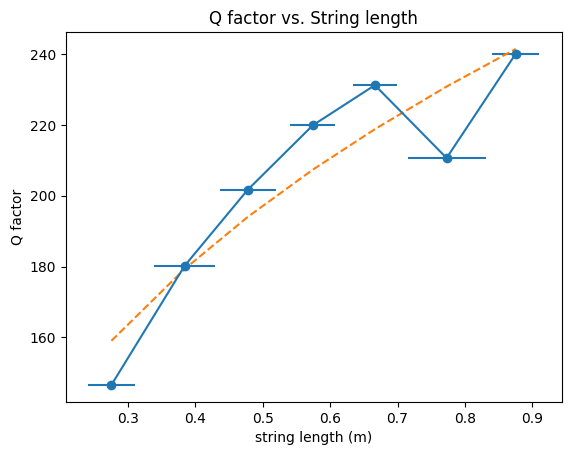

In [5]:
# you what
indices = [0, 1, 2, 3, 4, 5, 6]
lengths = np.array(lengths0)[indices]
lengths_uncert = np.array(lengths_uncert0)[indices]
q_factors = np.array(q_factors0)[indices]

# fit
def power_fun(x, a, k):
    return a * x**k

def log_fun(x, a, b):
    return a + b * np.log(x)

fun = power_fun

init_guess = (250., 0.5)
params, popv = scipy.optimize.curve_fit(
    fun, lengths, q_factors,
    p0=init_guess)
print(params)

# plot Q factor
plt.title("Q factor vs. String length")
plt.xlabel("string length (m)")
plt.ylabel("Q factor")
plt.errorbar(lengths, q_factors, xerr=lengths_uncert, fmt="o-")
plt.plot(lengths, fun(lengths, *params), "--")
plt.show()